In [58]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import PIL
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# Create DataFrame for Input and output

In [59]:
root_path = "catvsdog/PetImages/"
input_path = []
label = []

for class_name in os.listdir(root_path):
    for path in os.listdir(root_path + class_name):
        if class_name == 'Cat':
            label.append(0)
        else:
            label.append(1)
        input_path.append(os.path.join(root_path, class_name, path))

In [60]:
print(input_path[0], label[0])

catvsdog/PetImages/Cat\0.jpg 0


#### length of input_path and label 

In [61]:
len(input_path), len(label)

(24998, 24998)

In [62]:
df = pd.DataFrame({"Images_path": input_path,"Label": label})
df['Label'] = df['Label'].astype('str')
df.head()

,Images_path,Label
0,catvsdog/PetImages/Cat\0.jpg,0
1,catvsdog/PetImages/Cat\1.jpg,0
2,catvsdog/PetImages/Cat\10.jpg,0
3,catvsdog/PetImages/Cat\100.jpg,0
4,catvsdog/PetImages/Cat\1000.jpg,0


#### Check only `.jpg` file there into the dataset

In [63]:
for i in df['Images_path']:
    if '.jpg' not in i:
        print(i)

In [64]:
l = []
for image in df['Images_path']:
    try:
        img = PIL.Image.open(image)
    except:
        l.append(image)

In [65]:
l[:5]

[]

In [66]:
# to display grid of images
import random

plt.figure(figsize=(10,10))
temp = df[df['Label']==1]['Images_path']
start = random.randint(0, len(temp))
print(start)
files = temp[start:start+10]

for index, file in enumerate(files):
    plt.subplot(2,5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('Dogs')
    plt.axis('off')

0


<Figure size 1000x1000 with 0 Axes>

In [67]:
# to display grid of images
plt.figure(figsize=(25,25))
temp = df[df['Label']==0]['Images_path']
start = random.randint(0, len(temp))
files = temp[start:start+10]

for index, file in enumerate(files):
    plt.subplot(2,5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('Cats')
    plt.axis('off')

<Figure size 2500x2500 with 0 Axes>

# Spliting the dataset into training and testing

In [68]:
train, test = train_test_split(df, test_size = 0.2, random_state=42)

# Create DataGenerator for the images

In [69]:
# training data
train_generator = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation generator
val_generator = ImageDataGenerator(
    rescale=1.0/255
)

In [70]:
# train and validation iterator
train_iterator = train_generator.flow_from_dataframe(
    train, 
    x_col='Images_path', 
    y_col='Label', 
    target_size=(128,128), 
    batch_size=16, 
    class_mode='binary'
)

val_iterator = val_generator.flow_from_dataframe(
    test,
    x_col='Images_path', 
    y_col='Label', 
    target_size=(128,128), 
    batch_size=16, 
    class_mode='binary'
)

Found 19998 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


# Modeling - CNN

In [71]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [72]:
from keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [73]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 14, 14, 128)     

In [74]:
from keras.callbacks import EarlyStopping

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.01)

In [75]:
history = model.fit(
    train_iterator,
    epochs=100,
    validation_data=val_iterator,
    callbacks=[early_stopping]
)

Epoch 1/100
1250/1250 [==============================] - 43s 34ms/step - loss: 0.6137 - accuracy: 0.6526 - val_loss: 0.5598 - val_accuracy: 0.7128
Epoch 2/100
1250/1250 [==============================] - 42s 34ms/step - loss: 0.5179 - accuracy: 0.7426 - val_loss: 0.4555 - val_accuracy: 0.7848
Epoch 3/100
1250/1250 [==============================] - 43s 35ms/step - loss: 0.4760 - accuracy: 0.7730 - val_loss: 0.4753 - val_accuracy: 0.7720
Epoch 4/100
1250/1250 [==============================] - 43s 35ms/step - loss: 0.4401 - accuracy: 0.7938 - val_loss: 0.3853 - val_accuracy: 0.8272
Epoch 5/100
1250/1250 [==============================] - 44s 35ms/step - loss: 0.4171 - accuracy: 0.8084 - val_loss: 0.3615 - val_accuracy: 0.8448
Epoch 6/100
1250/1250 [==============================] - 43s 35ms/step - loss: 0.3884 - accuracy: 0.8242 - val_loss: 0.3688 - val_accuracy: 0.8396
Epoch 7/100
1250/1250 [==============================] - 43s 35ms/step - loss: 0.3753 - accuracy: 0.8313 - val_loss: 0

KeyboardInterrupt: 

# Visualization of Results

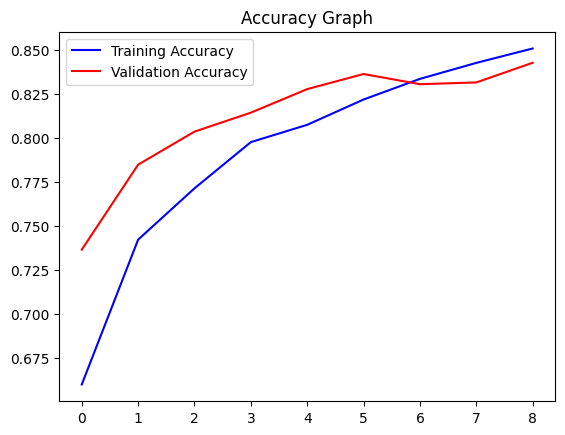

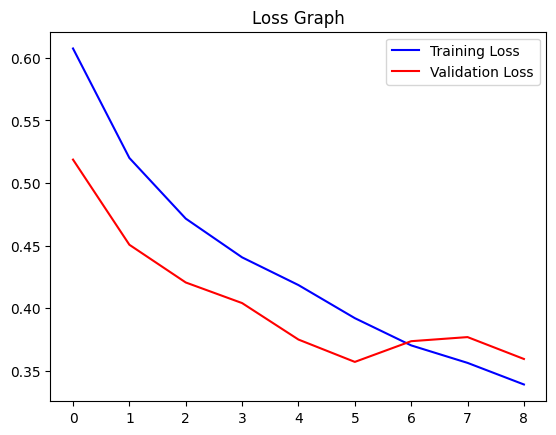

In [76]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [77]:
# Test generator
test_generator = ImageDataGenerator(
    rescale=1.0/255
)

# Test iterator
test_iterator = test_generator.flow_from_dataframe(
    test,  # Test DataFrame
    x_col='Images_path', 
    y_col='Label', 
    target_size=(128, 128),  # Resize to match model input
    batch_size=16,  # You can adjust the batch size
    class_mode='binary'  # Binary classification (Cat vs Dog)
)


Found 5000 validated image filenames belonging to 2 classes.


In [78]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_iterator)  # Use the test iterator
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")


313/313 [==============================] - 4s 12ms/step - loss: 0.1781 - accuracy: 0.9280
Test Accuracy: 0.9280
Test Loss: 0.1781


In [82]:
from tensorflow.keras.utils import load_img, img_to_array

# Path to your test image (change to an actual image path)
test_image_path = "catvsdog/PetImages/Dog/1.jpg"

# Load and preprocess the image
img = load_img(test_image_path, target_size=(128, 128))  # Resize to model input size
img_array = img_to_array(img) / 255.0  # Normalize pixel values
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Make prediction
prediction = model.predict(img_array)

# Interpret result
if prediction[0][0] > 0.5:
    print("🐶 It's a Dog!")
else:
    print("🐱 It's a Cat!")


1/1 [==============================] - 0s 12ms/step
🐶 It's a Dog!
